In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools as it 

In [2]:
path = "data/covid_19_clean_complete.csv"
df = pd.read_csv(path)
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


In [3]:
df_Colombia = df[df['Country/Region'] == 'Colombia']
df_Colombia

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
81,NaN,Colombia,4.5709,-74.2973,2020-01-22,0,0,0,0,Americas
342,NaN,Colombia,4.5709,-74.2973,2020-01-23,0,0,0,0,Americas
603,NaN,Colombia,4.5709,-74.2973,2020-01-24,0,0,0,0,Americas
864,NaN,Colombia,4.5709,-74.2973,2020-01-25,0,0,0,0,Americas
1125,NaN,Colombia,4.5709,-74.2973,2020-01-26,0,0,0,0,Americas
...,...,...,...,...,...,...,...,...,...,...
47844,NaN,Colombia,4.5709,-74.2973,2020-07-23,226373,7688,107951,110734,Americas
48105,NaN,Colombia,4.5709,-74.2973,2020-07-24,233541,7975,113864,111702,Americas
48366,NaN,Colombia,4.5709,-74.2973,2020-07-25,240795,8269,119667,112859,Americas
48627,NaN,Colombia,4.5709,-74.2973,2020-07-26,240795,8269,119667,112859,Americas


In [4]:
df_Colombia.isnull().sum()

Province/State    188
Country/Region      0
Lat                 0
Long                0
Date                0
Confirmed           0
Deaths              0
Recovered           0
Active              0
WHO Region          0
dtype: int64

In [5]:
df_Colombia = df_Colombia.drop('Province/State', axis=1)
df_Colombia.isnull().sum()

Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
WHO Region        0
dtype: int64

In [6]:
df_Colombia

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
81,Colombia,4.5709,-74.2973,2020-01-22,0,0,0,0,Americas
342,Colombia,4.5709,-74.2973,2020-01-23,0,0,0,0,Americas
603,Colombia,4.5709,-74.2973,2020-01-24,0,0,0,0,Americas
864,Colombia,4.5709,-74.2973,2020-01-25,0,0,0,0,Americas
1125,Colombia,4.5709,-74.2973,2020-01-26,0,0,0,0,Americas
...,...,...,...,...,...,...,...,...,...
47844,Colombia,4.5709,-74.2973,2020-07-23,226373,7688,107951,110734,Americas
48105,Colombia,4.5709,-74.2973,2020-07-24,233541,7975,113864,111702,Americas
48366,Colombia,4.5709,-74.2973,2020-07-25,240795,8269,119667,112859,Americas
48627,Colombia,4.5709,-74.2973,2020-07-26,240795,8269,119667,112859,Americas


In [7]:
dates = df_Colombia[["Date", "Confirmed", "Deaths", "Recovered", "Active"]].copy()
dates['Date'] = pd.to_datetime(dates['Date'])
dates = dates.set_index(dates['Date']).drop("Date",axis=1).resample('D').sum()
dates

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-22,0,0,0,0
2020-01-23,0,0,0,0
2020-01-24,0,0,0,0
2020-01-25,0,0,0,0
2020-01-26,0,0,0,0
...,...,...,...,...
2020-07-23,226373,7688,107951,110734
2020-07-24,233541,7975,113864,111702
2020-07-25,240795,8269,119667,112859


In [8]:
dates.describe()

,Confirmed,Deaths,Recovered,Active
count,188.000000,188.000000,188.000000,188.000000
mean,36665.542553,1258.111702,15020.271277,20387.159574
std,61000.321766,2091.025748,27977.236028,31239.401632
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000
50%,5011.500000,229.000000,1035.000000,3747.500000
75%,44064.500000,1446.750000,16766.000000,25851.750000
max,257101.000000,8777.000000,131161.000000,117163.000000


In [9]:
def show_linePlot(df, y_type = "N.N", title = "", palette = "deep"):
    colors = sns.color_palette(palette)
    color = random.choice(colors)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    sns.lineplot(df, x=df.index, y=y_type, color=color)    
    plt.grid(True)
    plt.show()


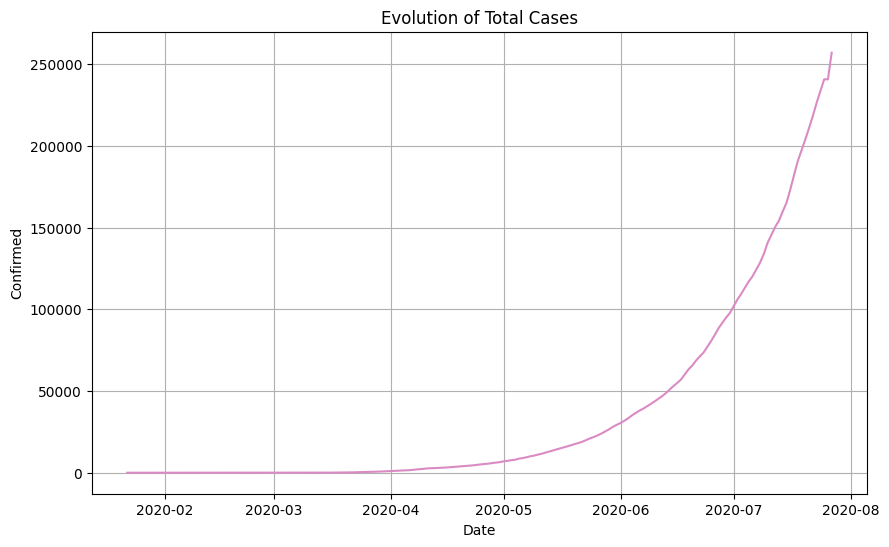

In [10]:
show_linePlot(dates, "Confirmed", "Evolution of Total Cases")

The confirmed COVID-19 cases in Colombia show a clear exponential trend, particularly intensifying after May 2020 (2020-04). This indicates uncontrolled community spread during that period. The curve's steep rise toward the end suggests an acceleration in transmission, likely due to loosening restrictions or increased testing/reporting.

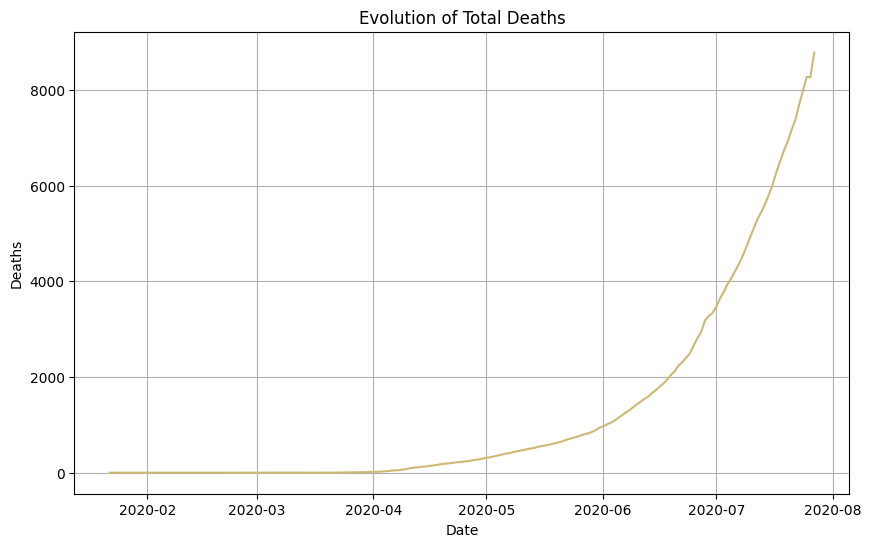

In [11]:
show_linePlot(dates, "Deaths", "Evolution of Total Deaths")

The total number of deaths also follows an exponential increase, mirroring the rise in confirmed cases. The lag between confirmed cases and deaths is expected due to the incubation period by COVID-19 and progression of the disease. This curve suggests a growing burden on the healthcare system and indicates that a high proportion of confirmed cases during this period were severe.

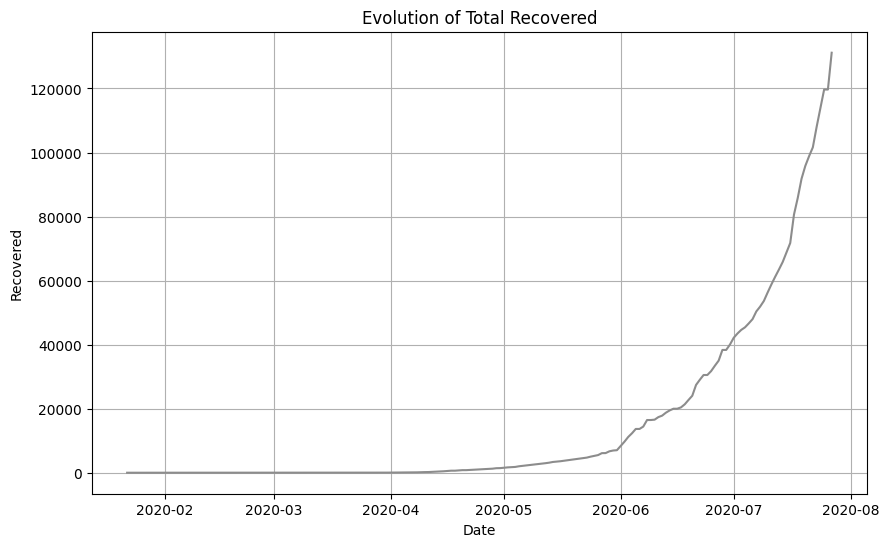

In [12]:
show_linePlot(dates, "Recovered", "Evolution of Total Recovered")

Recovery rates increased with the confirmed cases, indicating that many patients eventually overcame the illness. The sharp increase after June (2020-06) reflects better case management or more complete reporting of recoveries. However, the number of active cases still remains high, meaning recoveries weren’t outpacing new infections during this period.

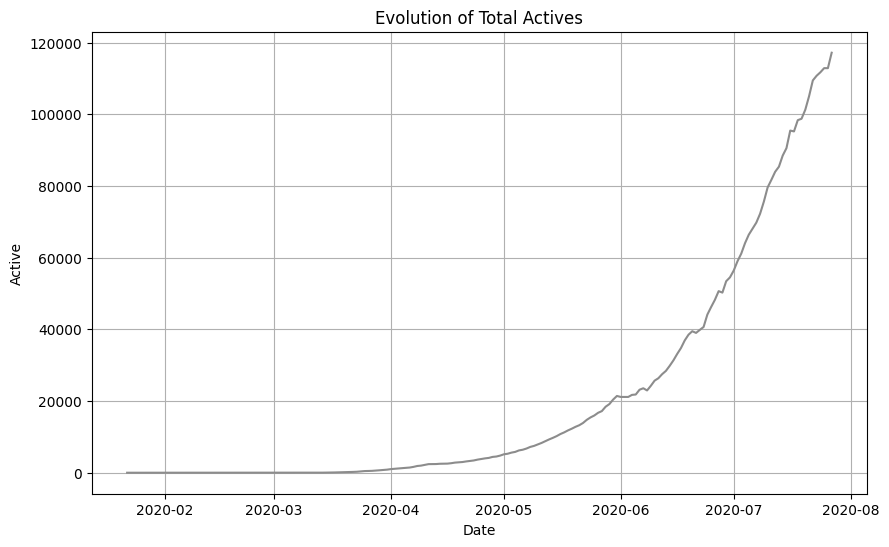

In [13]:
show_linePlot(dates, "Active", "Evolution of Total Actives")

Active cases increased over time, implying that more people were infected than were recovering or dying during this window. This trend is critical because it reflects the current pressure on hospitals, isolation systems, and public health infrastructure. The lack of flattening indicates that the outbreak was still far from being controlled by early August 2020.

## Growth Rate
Using this formula:

$$
\text{Growth Rate} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}}
$$

In [14]:
growth_rt = pd.DataFrame()
growth_rt['Growth Rate Confirmed'] = (dates["Confirmed"] - dates["Confirmed"].shift(1)) / dates["Confirmed"].shift(1) * 100
growth_rt['Growth Rate Deaths'] = (dates["Deaths"] - dates["Deaths"].shift(1)) / dates["Deaths"].shift(1) * 100
growth_rt['Growth Rate Recovered'] = (dates["Recovered"] - dates["Recovered"].shift(1)) / dates["Recovered"].shift(1) * 100
growth_rt['Growth Rate Active'] = (dates["Active"] - dates["Active"].shift(1)) / dates["Active"].shift(1) * 100

In [15]:
growth_rt.dropna()

,Growth Rate Confirmed,Growth Rate Deaths,Growth Rate Recovered,Growth Rate Active
Date,,,,
2020-03-22,17.857143,inf,200.000000,15.897436
2020-03-23,19.913420,50.000000,0.000000,19.911504
2020-03-24,36.462094,0.000000,100.000000,36.162362
2020-03-25,24.338624,33.333333,33.333333,24.119241
2020-03-26,4.468085,50.000000,0.000000,4.148472
...,...,...,...,...
2020-07-23,3.637354,4.272345,6.237391,1.180534
2020-07-24,3.166455,3.733091,5.477485,0.874167
2020-07-25,3.106093,3.686520,5.096431,1.035792


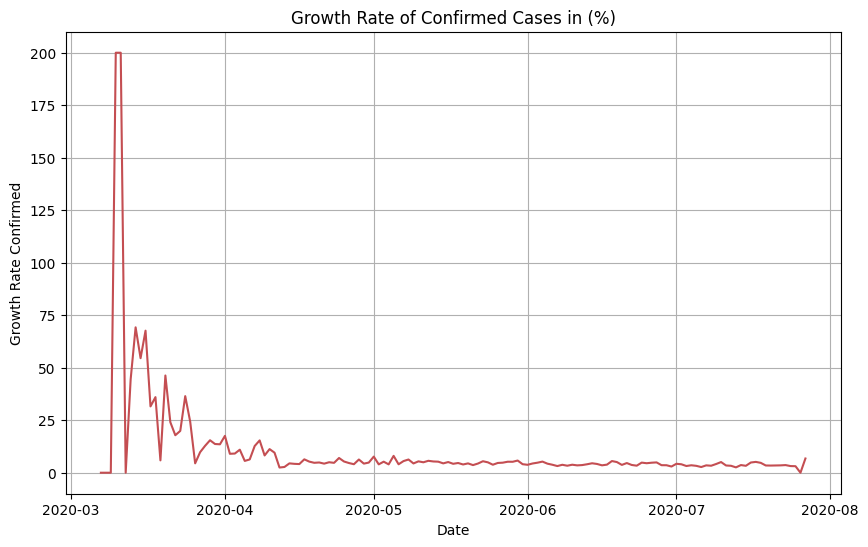

In [16]:
show_linePlot(growth_rt, "Growth Rate Confirmed", "Growth Rate of Confirmed Cases in (%)")

The initial surge in growth rate is typical in the early phase of an epidemic where each new case represents a large relative increase. After April (2020-04), the growth rate decreases and stabilizes, indicating that while cases were still rising, the speed of that increase was slowing — possibly due to early containment efforts or population adaptation to health measures.

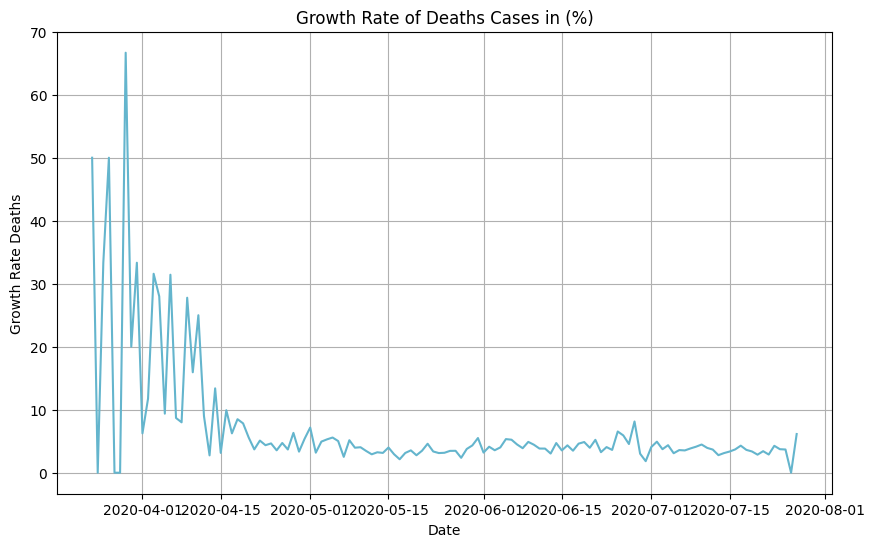

In [17]:
show_linePlot(growth_rt, "Growth Rate Deaths", "Growth Rate of Deaths Cases in (%)")

This curve shows initial instability due to low death counts at the beginning (small denominators inflate percentage changes). As deaths accumulated, the growth rate dropped and became more predictable, indicating a steadier mortality trend aligned with the increase in confirmed cases. The data appears consistent with expectations for a maturing epidemic curve.

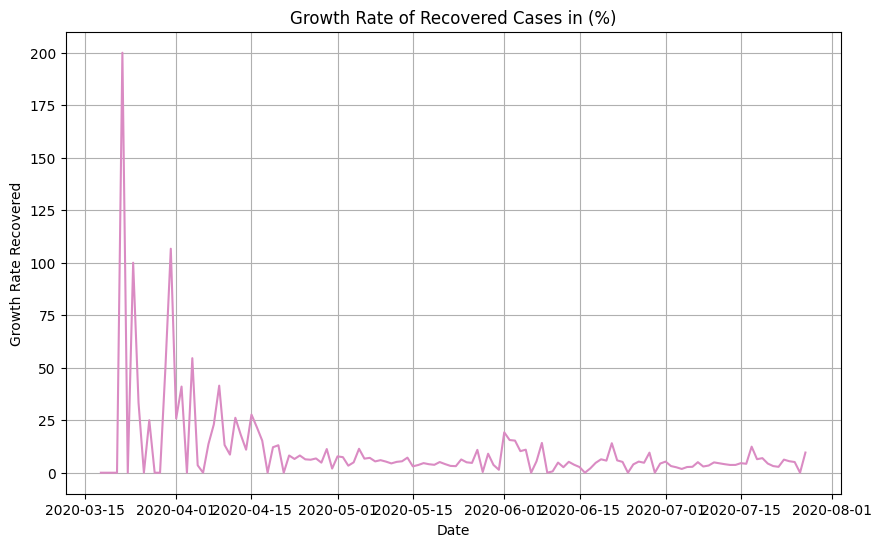

In [18]:
show_linePlot(growth_rt, "Growth Rate Recovered", "Growth Rate of Recovered Cases in (%)")

The initial volatility again reflects small base numbers. The increasing number of recovered patients later leads to more stable growth. A consistent recovery rate with a lower confirmed growth rate is a sign of potential control, although in this period active cases were still rising, showing recoveries were not catching up.

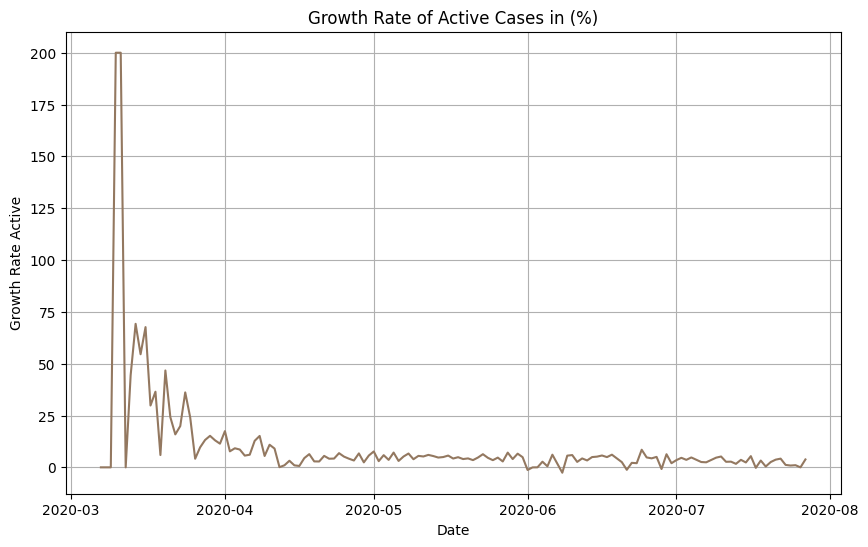

In [19]:
show_linePlot(growth_rt, "Growth Rate Active", "Growth Rate of Active Cases in (%)")

This trend mirrors the confirmed case growth rate, which is expected since active cases depend directly on confirmed minus recovered and deaths. The stabilization suggests that the epidemic was growing, but no longer accelerating. This is a crucial sign of approaching a potential plateau if sustained.

The growth rates are internally consistent:

- Early spikes are expected due to small denominators.

- Confirmed and active rates move in parallel — logical since actives = confirmed - (deaths + recovered).

- Death and recovery rates stabilize slightly later, as outcomes naturally lag behind infection confirmation.

- The flattening of all curves suggests the epidemic was progressing but not exploding by July.

Conclusion: These curves reflect a realistic epidemic progression: explosive start, followed by a stabilizing but sustained growth. There's coherence in their relative behaviors, and no anomalies suggesting data corruption or miscalculation.

## Fatality and Recovery

In [20]:
dates['Fatality Rate (%)'] = (dates['Deaths'] / dates['Confirmed']) * 100
dates['Recovery Rate (%)'] = (dates['Recovered'] / dates['Confirmed']) * 100

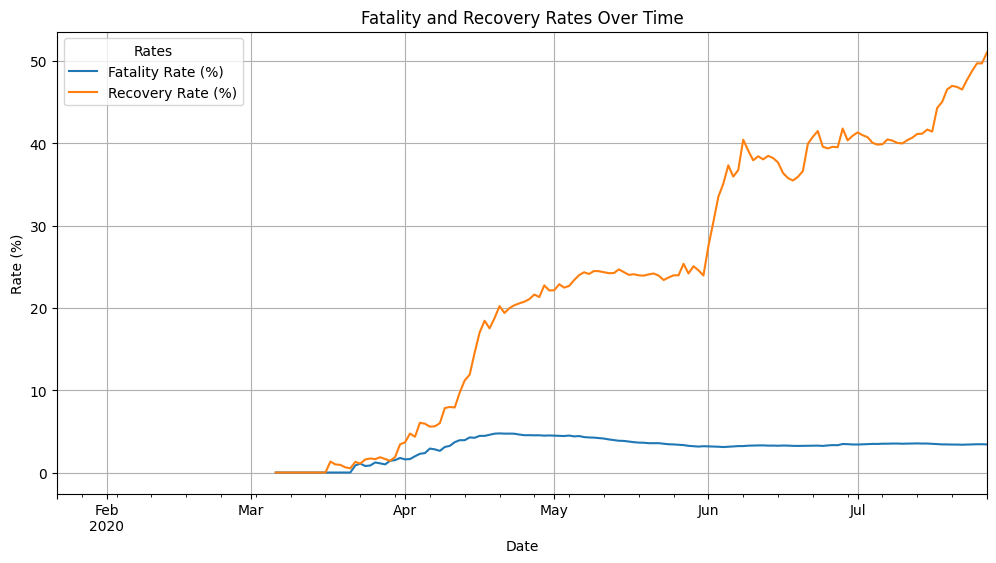

In [21]:
ax = dates[['Fatality Rate (%)', 'Recovery Rate (%)']].plot(figsize=(12, 6))
ax.set_title('Fatality and Recovery Rates Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Rate (%)')
plt.grid(True)
plt.legend(title="Rates", loc="best")
plt.show()


Fatality Rate (%)

- The fatality rate remains relatively low and stable, fluctuating between 3% and 5% after mid-April. This suggests that although COVID-19 was spreading rapidly in Colombia, the proportion of deaths relative to confirmed cases stayed controlled. The early slight increase can be attributed to low numbers of confirmed cases and delayed reporting of recoveries.

Recovery Rate (%)

- The recovery rate shows a strong upward trend, especially after April. It increases from near 0% to over 50% by the end of July. There are two visible jumps, one around early **May**, and another sharper increase in early **June** which might be due to bulk updates in recovery data or changes in health authority reporting protocols.

**Summary**

- The gap between recovery and fatality rates widens significantly, indicating a positive public health trajectory.

- A stable fatality rate + increasing recovery rate implies that while the virus was spreading, treatment outcomes were improving or recovery tracking became more accurate.

- These trends are coherent with the previously observed rise in total confirmed cases and active cases — while more people were getting infected, more were also recovering, keeping the fatality ratio in check.

<Axes: title={'center': 'COVID-19 Evolution in Colombia'}, xlabel='Date'>

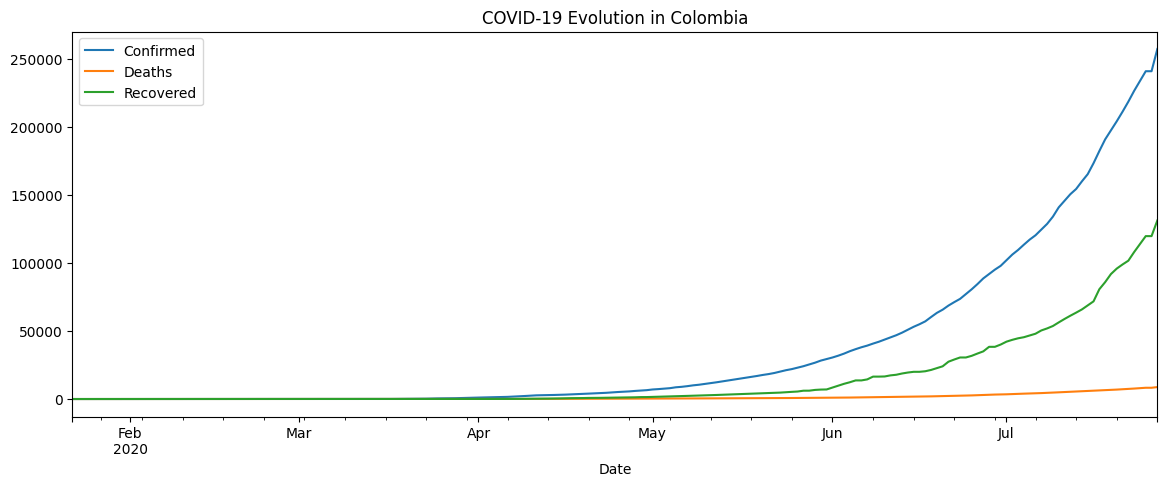

In [22]:
dates[['Confirmed', 'Deaths', 'Recovered']].plot(figsize=(14,5), title='COVID-19 Evolution in Colombia')

This chart offers a macro-level overview. The confirmed cases grow exponentially, indicating an expanding epidemic. Recovered cases begin to increase significantly after a delay, suggesting improved recovery tracking. Deaths grow more gradually, reflecting a relatively lower mortality impact. The divergence between confirmed and recovered lines widens until July, then begins to narrow.

### Daily Cases

In [23]:
daily = pd.DataFrame()
daily['Daily Confirmed'] = dates['Confirmed'].diff().fillna(0)
daily['Daily Deaths'] = dates['Deaths'].diff().fillna(0)
daily['Daily Recovered'] = dates['Recovered'].diff().fillna(0)


In [24]:
daily

,Daily Confirmed,Daily Deaths,Daily Recovered
Date,,,
2020-01-22,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0
...,...,...,...
2020-07-23,7945.0,315.0,6338.0
2020-07-24,7168.0,287.0,5913.0
2020-07-25,7254.0,294.0,5803.0


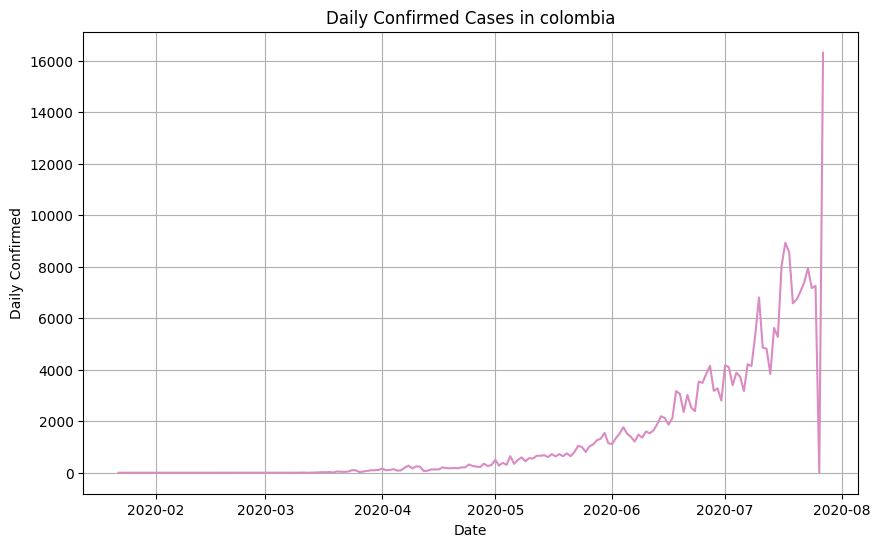

In [25]:
show_linePlot(daily, "Daily Confirmed", "Daily Confirmed Cases in colombia")

The daily confirmed curve reflects the epidemic's intensity in real time. The steady rise and oscillations in June–July indicate increased transmission and possibly higher testing. The sharp peak at the end is likely a data correction or batch update and should be handled as an outlier before modeling.

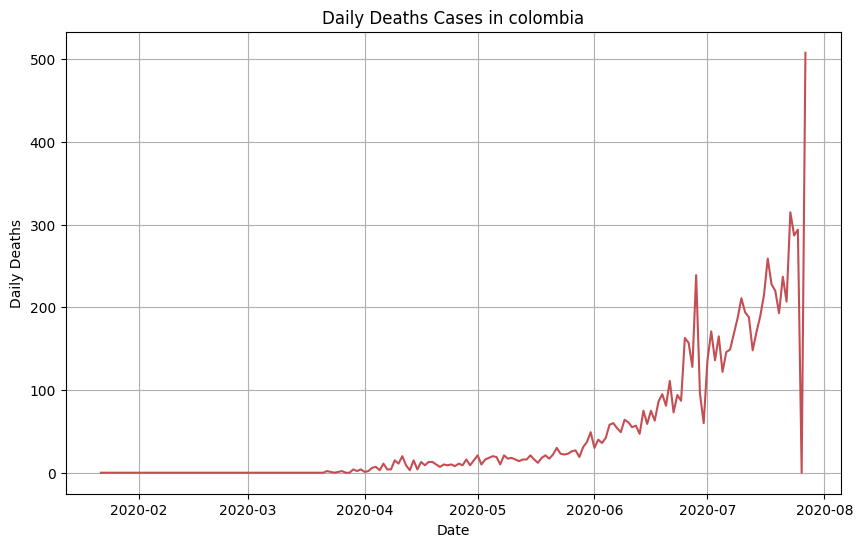

In [26]:
show_linePlot(daily, "Daily Deaths", "Daily Deaths Cases in colombia")

Similar to confirmed cases, this curve shows growing mortality as the virus spreads. The large fluctuations suggest possible data reporting delays (e.g., weekend lags). The end-of-period spike may coincide with the confirmed case spike reinforcing the need to validate those dates as possible anomalies.

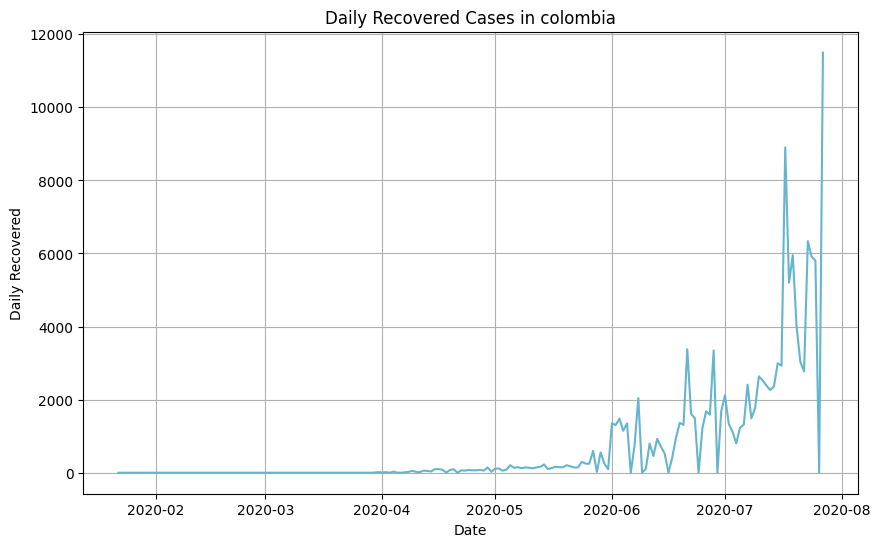

In [27]:
show_linePlot(daily, "Daily Recovered", "Daily Recovered Cases in colombia")

The high variability reflects inconsistencies in recovery reporting. Some recoveries are likely reported in bulk, causing sharp peaks followed by drops. This pattern may reflect administrative updates rather than actual epidemiological changes, and makes recovery data less suitable for sensitive time series modeling unless smoothed.

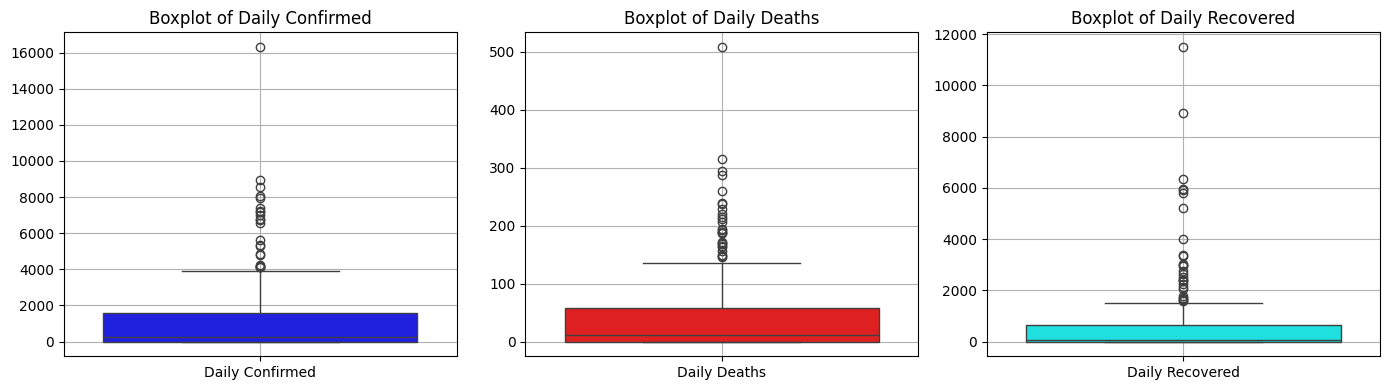

In [28]:
columns = ['Daily Confirmed', 'Daily Deaths', 'Daily Recovered']
colors = ['blue', 'red' ,'cyan']
plt.figure(figsize=(14, 4))

for i, column in enumerate(columns):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=daily[[column]], color=colors[i])
    plt.title(f"Boxplot of {column}")
    plt.grid(True)

plt.tight_layout()
plt.show()

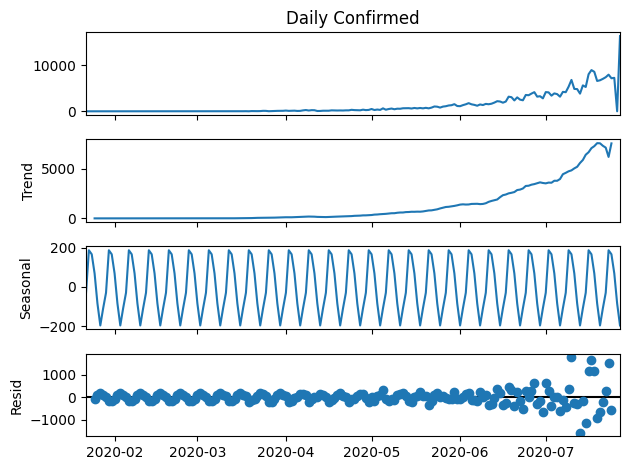

In [29]:
decomp = seasonal_decompose(daily['Daily Confirmed'], model='additive', period=7)
decomp.plot()
plt.show()

Trend:

- Long-term growth curve increases sharply, especially after May 2020.

Seasonal:

- Shows clear weekly periodicity very regular oscillations with 7-day cycles, likely due to weekly testing/reporting  patterns (e.g., weekend underreporting).

Residual:

- Appears centered around zero, but residual variance increases over time, showing more noise as the pandemic evolves — which is typical in  epidemic data.

Interpretation:

- This decomposition confirms that the time series is composed of non-stationary trend, strong seasonality, and residual noise. Before ARIMA, we need to remove trend and seasonality or difference the series appropriately.

In [30]:
result = adfuller(daily['Daily Confirmed'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')


ADF Statistic: 2.8214057237710777
p-value: 1.0
Critical Value 1%: -3.468952197801766
Critical Value 5%: -2.878495056473015
Critical Value 10%: -2.57580913601947


### Spliting Data

In [31]:
ts = daily["Daily Confirmed"]
train = ts[:-14]
test = ts[-14:]

In [32]:
p = d = q = range(0,6)
pdq = list(it.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (1, 4, 5),
 (1, 5, 0),
 (1, 5, 1),
 (1, 5, 2),
 (1, 5, 3),
 (1, 5, 4),
 (1, 5, 5),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2,

In [33]:
warnings.filterwarnings("ignore") 

min_aic = 100000
best_param = None

for param in pdq:
    try:
        model = ARIMA(train, order = param)
        model_fit = model.fit()
        curr_aic = model_fit.aic
        if curr_aic < min_aic:
            min_aic = curr_aic
            best_param = param
        print(f"{param}, with AIC: { model_fit.aic}")
        print()
    except:
        continue

(0, 0, 0), with AIC: 3006.7227818867077

(0, 0, 1), with AIC: 2806.3447169753053

(0, 0, 2), with AIC: 2766.63712832908

(0, 0, 3), with AIC: 2639.281823183541

(0, 0, 4), with AIC: 2686.3457915283993

(0, 0, 5), with AIC: 2595.6957923653144

(0, 1, 0), with AIC: 2501.883915333713

(0, 1, 1), with AIC: 2491.4834690199523

(0, 1, 2), with AIC: 2488.125852401286

(0, 1, 3), with AIC: 2489.994193349825

(0, 1, 4), with AIC: 2477.717323144783

(0, 1, 5), with AIC: 2460.1232875239093

(0, 2, 0), with AIC: 2638.5034310475085

(0, 2, 1), with AIC: 2494.6400681067207

(0, 2, 2), with AIC: 2479.203135867745

(0, 2, 3), with AIC: 2457.3158910056454

(0, 2, 4), with AIC: 2458.9436469109487

(0, 2, 5), with AIC: 2458.4714116134865

(0, 3, 0), with AIC: 2816.984699143278

(0, 3, 1), with AIC: 2630.6112888016996

(0, 3, 2), with AIC: 2494.3190406820827

(0, 3, 3), with AIC: 2476.605274899107

(0, 3, 4), with AIC: 2498.412184972629

(0, 3, 5), with AIC: 2456.217891902009

(0, 4, 0), with AIC: 3001.59

In [34]:
print(f"\nBest ARIMA{best_param} - AIC: {min_aic:.2f}")


Best ARIMA(5, 2, 4) - AIC: 2421.04


In [35]:
model = ARIMA(train, order=best_param)
model_fit = model.fit()

forecast = model_fit.forecast(steps=14)

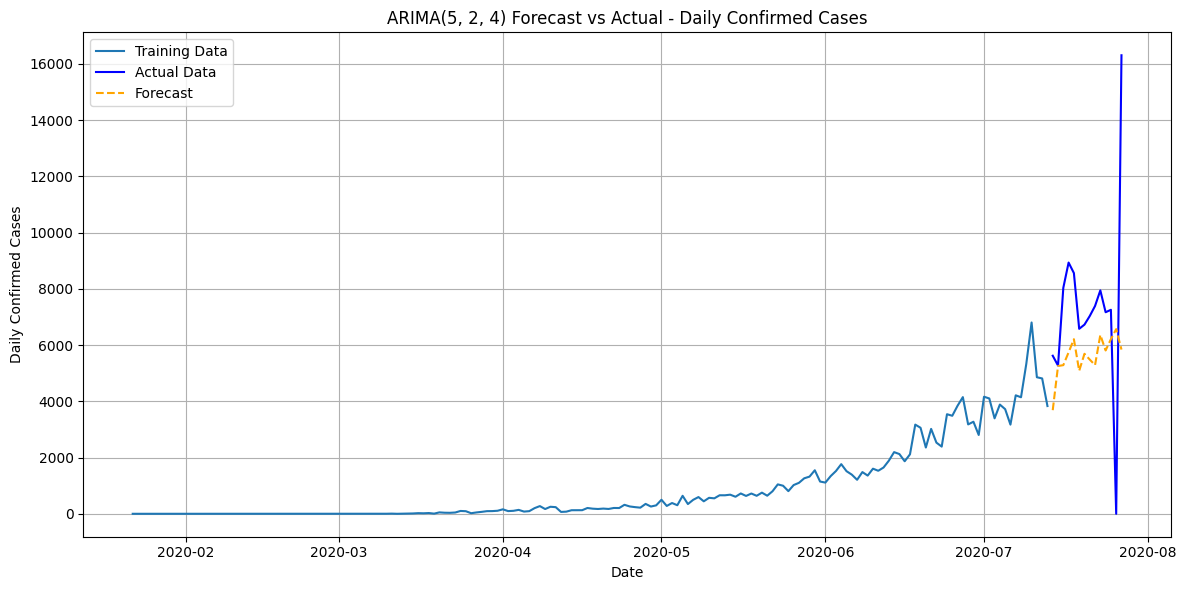

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange', linestyle='--')

plt.title(f'ARIMA{best_param} Forecast vs Actual - Daily Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 2674.85
RMSE: 3734.65
MAPE: inf%


In [38]:
sarima_model = SARIMAX(
    train,
    order=(2, 2, 2),
    seasonal_order=(1, 1, 1, 7),  # SARIMA(p,d,q)(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(test))

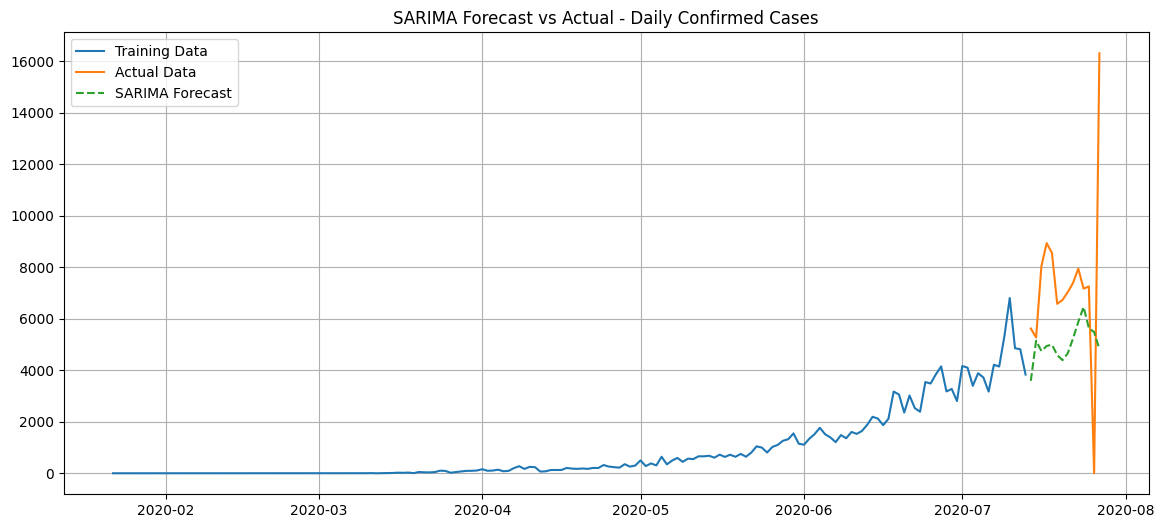

In [39]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title("SARIMA Forecast vs Actual - Daily Confirmed Cases")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
mae = mean_absolute_error(test, sarima_forecast)
rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
mape = np.mean(np.abs((test - sarima_forecast) / sarima_forecast)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 3086.60
RMSE: 4075.65
MAPE: 63.00%


In [41]:
warnings.filterwarnings("ignore")  

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 7  # weekendly

pdq = list(it.product(p, d, q))
seasonal_pdq = list(it.product(P, D, Q, [s]))

best_aic = float("inf")
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(
                train,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
            print(f"SARIMA{param}x{seasonal_param} - AIC: {results.aic:.2f}")
        except:
            continue

print(f"\nBest SARIMA configuration: {best_params} with AIC: {best_aic:.2f}")


SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC: 3050.33
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC: 2782.45
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC: 2517.84
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC: 2414.03
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC: 2441.36
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC: 2366.62
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC: 2422.35
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC: 2351.54
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC: 2826.95
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC: 2615.84
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC: 2457.55
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC: 2362.25
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC: 2439.31
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC: 2350.65
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC: 2390.04
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC: 2335.25
SARIMA(0, 0, 2)x(0, 0, 0, 7) - AIC: 2722.30
SARIMA(0, 0, 2)x(0, 0, 1, 7) - AIC: 2568.58
SARIMA(0, 0, 2)x(0, 1, 0, 7) - AIC: 2439.47
SARIMA(0, 0, 2)x(0, 1, 1, 7) - AIC: 2343.59
SARIMA(0, 0, 2)x(1, 0, 0, 7) - AIC: 2441.78
SARIMA(0, 0, 2)x(1, 0, 1, 7) - AIC: 2338.83
SARIMA(0, 0, 2)x(1, 1, 0, 7) - A

In [42]:
best_order, best_seasonal_order = best_params

sarima_opt = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_opt.fit(disp=False)

In [43]:
forecast_sarima = sarima_result.predict(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)

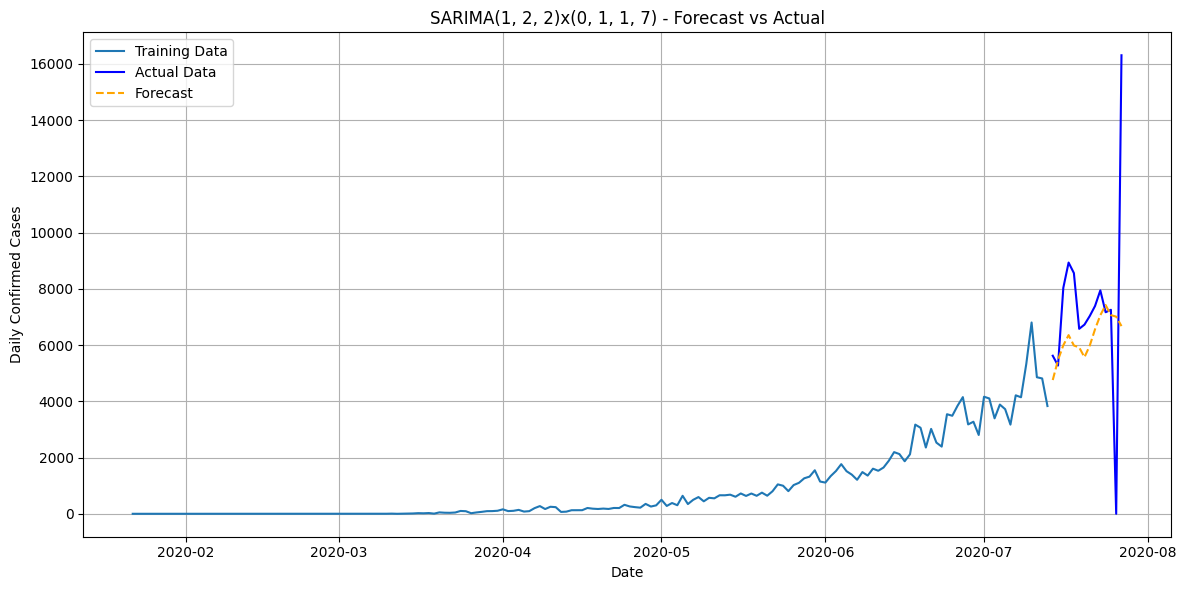

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='blue')
plt.plot(forecast_sarima, label='Forecast', linestyle='--', color='orange')
plt.title(f"SARIMA{best_order}x{best_seasonal_order} - Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
mae = mean_absolute_error(test, forecast_sarima)
rmse = np.sqrt(mean_squared_error(test, forecast_sarima))
mape = np.mean(np.abs((test - forecast_sarima) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 2138.25
RMSE: 3429.23
MAPE: inf%


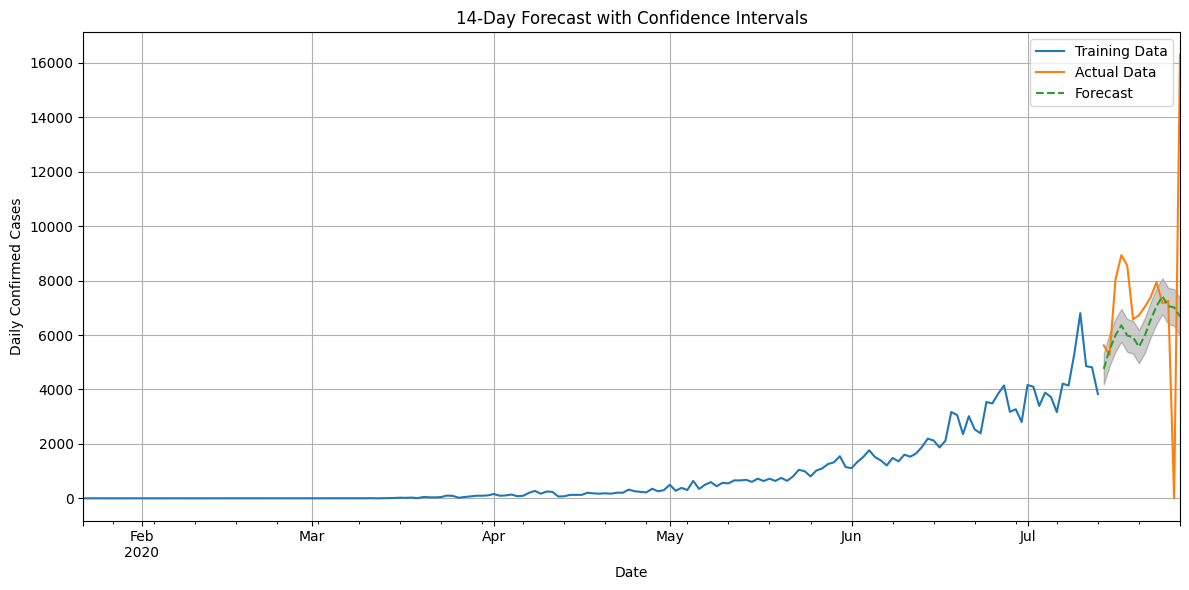

In [47]:
pred_uc = sarima_result.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()

ax = train.plot(label='Training Data', figsize=(12, 6))
test.plot(ax=ax, label='Actual Data')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linestyle='--')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Confirmed Cases')
ax.set_title('14-Day Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
n_steps = 30   #30 days
future_forecast = sarima_result.get_forecast(steps=n_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

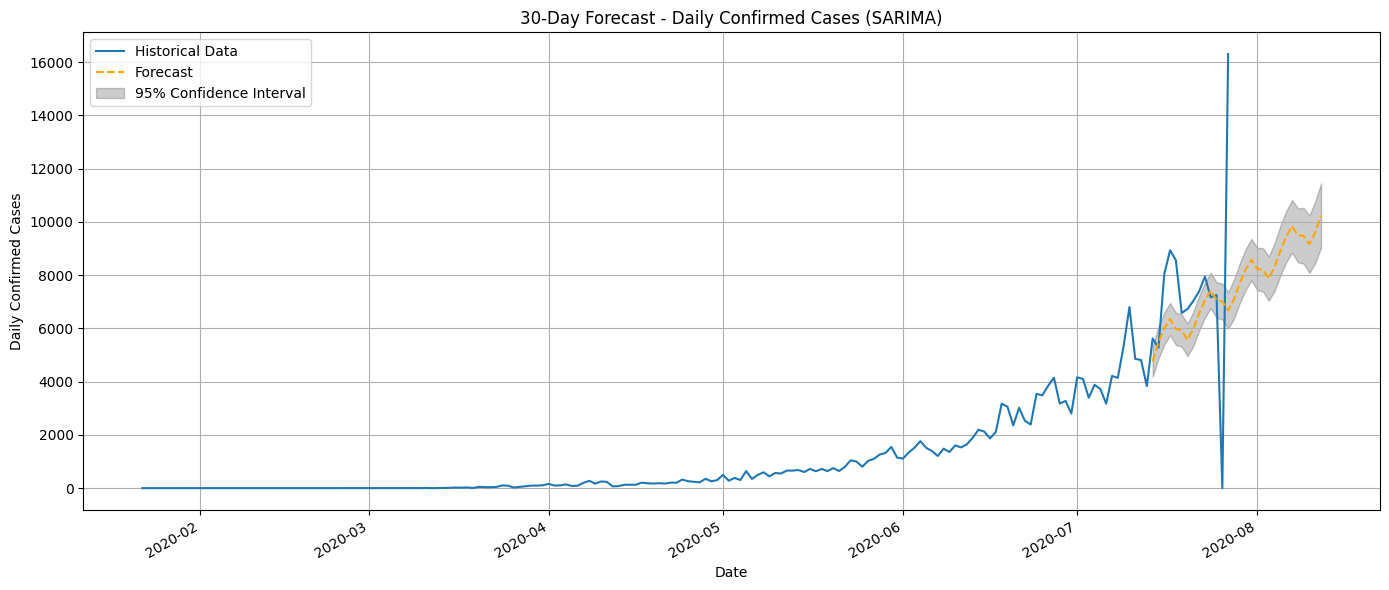

In [49]:
plt.figure(figsize=(14, 6))
plt.plot(daily['Daily Confirmed'], label="Historical Data")

future_mean.plot(label="Forecast", linestyle='--', color='orange')

plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1],
                 color='k', alpha=0.2, label='95% Confidence Interval')

plt.title(f'{n_steps}-Day Forecast - Daily Confirmed Cases (SARIMA)')
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
